# Logistic Regression
### `! git clone https://github.com/ds3001f25/logistic_regression.git`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import seaborn as sns

## A Motivating Example
- Remember our heart failure problem? `DEATH_EVENT=0` means the patient survived, and `DEATH_EVENT=1` means the patient died

In [2]:
from sklearn.linear_model import LinearRegression

df = pd.read_csv('./data/heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## A Motivating Example
- Let's make a quick linear model and take a look at the predictions it makes
- (We won't bother with the train-test split, because we're just playing with the linear model framework on this occasion)
- Since the linear model is predicted a binary outcome, we interpret its value as a probability

R^2:  0.2360829823571553


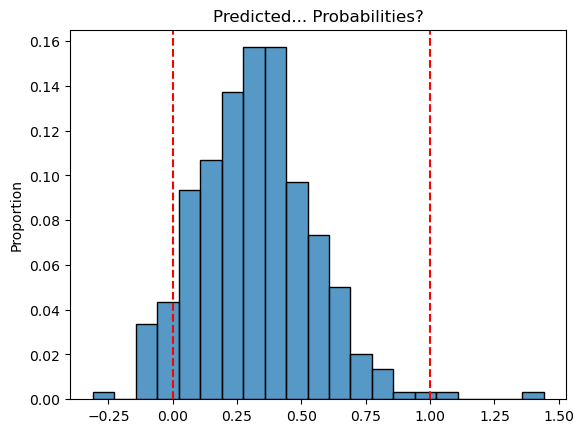

In [3]:
y = df['DEATH_EVENT']
X = df.drop(['DEATH_EVENT', 'time'],axis=1)

reg = LinearRegression()
reg = reg.fit(X,y)
print('R^2: ', reg.score(X,y))
y_hat = reg.predict(X)

sns.histplot(y_hat,stat='proportion').set(title='Predicted... Probabilities?')
plt.axvline(x=0, color='red', linestyle='--')
plt.axvline(x=1, color='red', linestyle='--')

## Linear Probability Models
- There are a substantial number of outcomes below zero and above one. We can't interpret these as probabilities.
- If there are only a few violations not far below zero or above one, we might shrug and put up with it. The linear model is very explainable, easy to compute, and so on.
- But if we need this for clinical purposes, this many violations of these sizes suggests the linear model isn't a good tool.

- Do we have another alternative?
- We're going to resolve this issue by looking at **Logistic Regression**, which is also our path to neural networks 

# Logistic Regression

## Latent Variables
- One of our complaints about linear models for predicting a binary class or a probability is that it might take values less than zero or greater than 1
- There are a variety of ways to fix this, but the most popular are **probit** and **logit**

- The basic premise of these models is that -- along with features $x_i$ -- there is an **unobserved** linear index or **latent variable**,
$$ L_i = b \cdot x_i + \varepsilon_i,$$
but what **is** observed is
$$ y_i = \begin{cases} 1, & L_i \ge 0 \\ 0, & L_i < 0 \end{cases} $$
- So if the latent index is large or the shock is particularly large, you'll observe a 1; otherwise you observe a zero
- This is a great trick for situations where numeric covariates determine categorical or binary or integer-valued outcomes

## Examples
- What is the probability a test pilot loses consciousness ($y_i =1, 0$) in a high risk scenario, based on physiological data $x_i$? (original application)
- Who buys a new car or washing machine this year ($y_i =1, 0$), based on socio-economic characteristics $x_i$?
- Does a county elect a Democrat or Republican representative?
- Are you hired for a job or denied a loan ($y_i = 0, 1$), based on your qualifications $x_i$?

## Logistic Regression
- To fit these models, we first pick a distribution function for $\varepsilon_i$, $F(x) =pr[\varepsilon_i \le x]$:
    - If we pick the **logistic distribution**, 
    $$
    F(x) = \dfrac{1}{1+\exp(-x)},
    $$
    we get **Logistic Regression**
    - Notice that as $x \rightarrow \infty$, $F(x) \rightarrow 1$, and as $x \rightarrow -\infty$, $F(x) \rightarrow 0$, and $F(x)$ is increasing in $x$, so this is a value distribution function

![](src/Logistic-curve.png)

## Logistic Regression
- To fit these models, we first pick a distribution function for $\varepsilon_i$, $F(x) =pr[\varepsilon_i \le x]$:
    - If we pick the normal distribution, the probability of observing a 1 given $x_i$ is $\Phi(\varepsilon_i)$, where $\Phi$ is the standard normal distribution function, $$ \Phi(\varepsilon_i) = \int_{-\infty}^{\varepsilon_i} \dfrac{1}{\sqrt{2 \pi}} e^{-z^2/2} dz$$ and we get **Probit Regression**

- Today, there is little reason to pick one or the other, but 30-40 years ago, the logistic distribution had an advantage because it was easier to compute than the standard normal distribution, which involves numeric integration

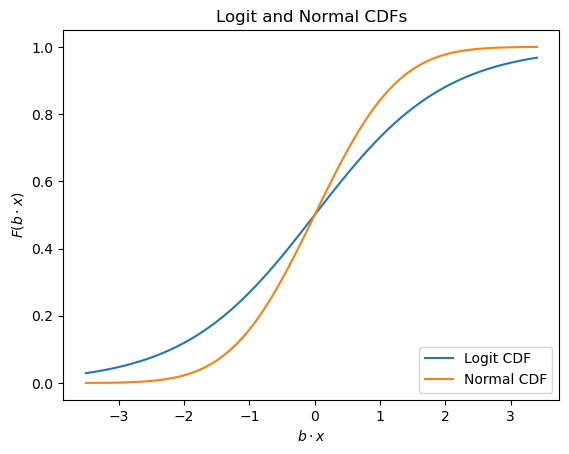

In [4]:
X = np.arange(-3.5,3.5,.1) # Create grid for plot

def F(L): # Logit distribution function
    p = 1/(1+np.exp(-L))
    return p

pr_logit = F(X) # Evaluate logit CDF on grid
pr_normal = norm.cdf(X) # Evaluate normal CDF on grid

# Plot:
plt.plot(X,pr_logit, label ='Logit CDF')
plt.plot(X, pr_normal, label='Normal CDF')
plt.xlabel("$b \\cdot x$")
plt.ylabel("$F(b\\cdot x)$")
plt.legend(loc='lower right')
plt.title('Logit and Normal CDFs')
plt.show()

## Logistic Regression
- What is the probability of observing a 0, given $x_i$? We want to make the following probability "look like" a distribution function so can swap in $F(x)=pr[\varepsilon_i \le x]$:
$$\begin{alignat*}{2}
pr[y=0|x] &=& pr[ b \cdot x_i + \varepsilon_i \le 0 ] \\
&=& pr[  \varepsilon_i \le - b \cdot x_i ] \\
&=& F( - b \cdot x_i) \\
&=& \dfrac{1}{1+\exp(b \cdot x_i)}
\end{alignat*}$$ 

- Since $pr[y=0|x] = 1 - pr[y=1|x]$, using our probability rules, that implies that
$$\begin{alignat*}{2}
pr[y=1|x] &=& 1 - \dfrac{1}{1+\exp(b \cdot x_i)} \\
&=& \dfrac{\exp(b \cdot x_i)}{1+\exp(b \cdot x_i)}\\
&=& \dfrac{1}{1+\exp(-b \cdot x_i)}
\end{alignat*}$$
As you vary $b$, it shapes the probability of observing $y=1$ or $y=0$, 

## Example: Price Discrimination
- The data: You observe data $x_i$ about a consumer and whether they purchased ($y_i=1$) or not ($y_i = 0$) at a price of $p_i$
- You want to build a model that describes how future consumers will respond to different prices.
- The consumer buys if their value, $v_i$, exceeds the price, $p_i$, or $v_i - p_i \ge 0$ 

- Model their net gain as $n_i = b \cdot x_i + \varepsilon_i - p_i$ and substitute into the logit model: $$ \begin{alignat*}{2} pr[\text{buy}|p_i, x_i] &=& pr[n_i \ge 0 ] \\
&=& pr[\varepsilon_i \ge -(b \cdot x_i - p_i) ] \\
&=& 1 - pr[\varepsilon_i < -(b \cdot x_i - p_i) ] \\
&=& 1 - F(-(b \cdot x_i - p_i)) \\
&=& 1 - \dfrac{1}{1+\exp(b \cdot x_i - p_i)} \\
&=&  \dfrac{1}{1+\exp(p_i - b \cdot x_i)} \end{alignat*}$$
- So you can map consumer characteristics into a probability of purchase. This is a workhorse model for price-setting.

## How to Fit A Logistic Regression Model
- You could compute the SSE of the predicted probabilities from the observed outcomes: This is called the **Brier Score**. That is not what most people do.
- Instead, we ask, "What is the probability of observing these data, given $b$?" That is the **likelihood function**
- We then pick the $b$ that maximizes the likelihood function; this is called **maximum likelihood estimation**

- Then the probability of observing these $y$ given $x$ and $b$ is given by the **likelihood function**,
$$ pr[y|x,b] = \prod_{i =1}^N \left(\dfrac{1}{1+\exp(-b \cdot x_i)}\right)^{y_i} \times  \left(  \dfrac{1}{1+\exp(b \cdot x_i)}\right)^{1-y_i}$$
- This is called **maximum likelihood estimation**, and is an alternative way to approach the problem of picking parameters $b$ to fit a model to data that has excellent statistical properties

## Binary Cross Entropy
- Because the likelihood function is a product of probabilities, we typically take the natural logarithm to convert the product into a sum; since the log function is increasing, the two problems have the same solution.
- The **log likelihood**, which statistics people want to maximize, is
$$
\ell \ell(b) = \sum_{i=1}^N y_i \log \left( \hat{p}_i(b) \right) + (1-y_i) \log \left( 1-\hat{p}_i(b) \right) 
$$
and the **binary cross entropy**, which CS people want to minimize, is
$$
\text{bce}(b) = - \sum_{i=1}^N y_i \log \left( \hat{p}_i(b) \right) + (1-y_i) \log \left( 1-\hat{p}_i(b) \right) 
$$
- These are the same, it's just which community is writing the model down
- This is not a linear model

## SciKit
- Scikit, of course, has a package for all this:
    - `from sklearn.linear_model import LogisticRegression`
    - It happens that **SciKit logistic regression is not logistic regression**. **You must add an option,`penalty=None`, to get vanilla logistic regression and not the spicy version, which has a very different solution**

- Logistic regression also has a `fit_intercept` option to handle the dummy variable trap, just like linear regression
- When using SciKit for nonlinear models, **min-max scale your numeric variables**; otherwise they're very unstable
- For a fitted model, you can use it for regression or classification:
    - `reg.predict(X)` will return a class label, 0 or 1
    - `reg.predict_probab(X)` will return probabilities between 0 and 1

# Example: Borrower Default

In [5]:
## Example
pd.set_option('display.max_columns', None)
df = pd.read_csv('./data/brazil_default.csv', encoding = 'latin1', low_memory = False)
df.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,STATE_OF_BIRTH,CITY_OF_BIRTH,NACIONALITY,RESIDENCIAL_STATE,RESIDENCIAL_CITY,RESIDENCIAL_BOROUGH,FLAG_RESIDENCIAL_PHONE,RESIDENCIAL_PHONE_AREA_CODE,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,FLAG_MOBILE_PHONE,FLAG_EMAIL,PERSONAL_MONTHLY_INCOME,OTHER_INCOMES,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_OTHER_CARDS,QUANT_BANKING_ACCOUNTS,QUANT_SPECIAL_BANKING_ACCOUNTS,PERSONAL_ASSETS_VALUE,QUANT_CARS,COMPANY,PROFESSIONAL_STATE,PROFESSIONAL_CITY,PROFESSIONAL_BOROUGH,FLAG_PROFESSIONAL_PHONE,PROFESSIONAL_PHONE_AREA_CODE,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,MATE_PROFESSION_CODE,EDUCATION_LEVEL.1,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6,1,0,RN,Assu,1,RN,Santana do Matos,Centro,Y,105,1.0,15.0,N,1,900.0,0.0,1,1,0,0,0,0,0,0.0,0,N,,NaN,NaN,N,,0,9.0,4.0,NaN,NaN,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,RJ,rio de janeiro,1,RJ,RIO DE JANEIRO,CAMPO GRANDE,Y,20,1.0,1.0,N,1,750.0,0.0,0,0,0,0,0,0,0,0.0,0,Y,,NaN,NaN,N,,0,11.0,4.0,11.0,NaN,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,RN,GARANHUNS,1,RN,Parnamirim,Boa Esperanca,Y,105,1.0,NaN,N,1,500.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,NaN,NaN,N,,0,11.0,NaN,NaN,NaN,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,PE,CABO,1,PE,CABO,PONTE DOS CARVALHOS,N,,NaN,NaN,N,1,500.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,NaN,NaN,N,,0,NaN,NaN,NaN,NaN,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,RJ,RIO DE JANEIRO,1,RJ,Rio de Janeiro,Santa Cruz,Y,20,1.0,12.0,N,1,1200.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,NaN,NaN,N,,0,9.0,5.0,NaN,NaN,0,0,0,0,1,N,48,235,235,1


In [6]:
df.describe()

,ID_CLIENT,PAYMENT_DAY,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,NACIONALITY,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,FLAG_EMAIL,PERSONAL_MONTHLY_INCOME,OTHER_INCOMES,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_OTHER_CARDS,QUANT_BANKING_ACCOUNTS,QUANT_SPECIAL_BANKING_ACCOUNTS,PERSONAL_ASSETS_VALUE,QUANT_CARS,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,MATE_PROFESSION_CODE,EDUCATION_LEVEL.1,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,AGE,TARGET_LABEL_BAD=1
count,50000.000000,50000.000000,50000.0,50000.000000,50000.00000,50000.000000,50000.0,50000.000000,48651.000000,46223.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,42244.000000,42687.000000,21116.000000,17662.000000,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.00000,50000.000000
mean,25000.500000,12.869920,0.0,1.006540,2.14840,0.650520,0.0,0.961600,1.252225,9.727149,0.802280,886.678437,35.434760,0.111440,0.097460,0.001320,0.001740,0.002040,0.357840,0.357840,2.322372e+03,0.336140,0.009320,8.061784,2.484316,3.797926,0.296003,0.0,0.0,0.0,0.0,1.275700,43.24852,0.260820
std,14433.901067,6.608385,0.0,0.080606,1.32285,1.193655,0.0,0.202105,0.867833,10.668841,0.398284,7846.959327,891.515142,0.314679,0.296586,0.036308,0.041677,0.045121,0.479953,0.479953,4.235798e+04,0.472392,0.383453,3.220104,1.532261,5.212168,0.955688,0.0,0.0,0.0,0.0,0.988286,14.98905,0.439086
min,1.000000,1.000000,0.0,1.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,6.00000,0.000000
25%,12500.750000,10.000000,0.0,1.000000,1.00000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,360.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,31.00000,0.000000
50%,25000.500000,10.000000,0.0,1.000000,2.00000,0.000000,0.0,1.000000,1.000000,6.000000,1.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,9.000000,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,41.00000,0.000000
75%,37500.250000,15.000000,0.0,1.000000,2.00000,1.000000,0.0,1.000000,1.000000,15.000000,1.000000,800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,9.000000,4.000000,11.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,53.00000,1.000000
max,50000.000000,25.000000,0.0,2.000000,7.00000,53.000000,0.0,2.000000,5.000000,228.000000,1.000000,959000.000000,194344.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,6.000000e+06,1.000000,35.000000,18.000000,5.000000,17.000000,5.000000,0.0,0.0,0.0,0.0,7.000000,106.00000,1.000000


In [7]:
df = pd.read_csv('./data/brazil_default.csv', encoding = 'latin1', low_memory = False)

df['Intercept'] = np.ones(df.shape[0])

num_var = ['Intercept','PERSONAL_MONTHLY_INCOME', 'OTHER_INCOMES','FLAG_EMAIL', 
          'FLAG_DINERS', 'FLAG_AMERICAN_EXPRESS', 'FLAG_MASTERCARD', 'FLAG_OTHER_CARDS', 
          'PERSONAL_ASSETS_VALUE']
cat_var = ['MARITAL_STATUS', 'QUANT_DEPENDANTS','QUANT_BANKING_ACCOUNTS', 'QUANT_CARS', 
           'EDUCATION_LEVEL.1','PROFESSION_CODE']

df = df.loc[:, ['TARGET_LABEL_BAD=1']+num_var+cat_var ]

In [8]:
df.isnull().describe()

,TARGET_LABEL_BAD=1,Intercept,PERSONAL_MONTHLY_INCOME,OTHER_INCOMES,FLAG_EMAIL,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_MASTERCARD,FLAG_OTHER_CARDS,PERSONAL_ASSETS_VALUE,MARITAL_STATUS,QUANT_DEPENDANTS,QUANT_BANKING_ACCOUNTS,QUANT_CARS,EDUCATION_LEVEL.1,PROFESSION_CODE
count,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
freq,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,32338,42244


In [9]:
# Clean missing professional codes:

print(df['PROFESSION_CODE'].value_counts())
df['PROFESSION_CODE'] = df['PROFESSION_CODE'].replace(np.nan,'Missing')
print(df['PROFESSION_CODE'].value_counts())

print(df['EDUCATION_LEVEL.1'].value_counts())
df['EDUCATION_LEVEL.1'] = df['EDUCATION_LEVEL.1'].replace(np.nan,'Missing')
print(df['EDUCATION_LEVEL.1'].value_counts())

PROFESSION_CODE
9.0     30092
11.0     3545
0.0      3540
2.0      2827
12.0      489
10.0      425
16.0      344
13.0      313
7.0       216
8.0       144
6.0       136
15.0       63
17.0       35
4.0        27
3.0        18
5.0        12
14.0        9
1.0         8
18.0        1
Name: count, dtype: int64
PROFESSION_CODE
9.0        30092
Missing     7756
11.0        3545
0.0         3540
2.0         2827
12.0         489
10.0         425
16.0         344
13.0         313
7.0          216
8.0          144
6.0          136
15.0          63
17.0          35
4.0           27
3.0           18
5.0           12
14.0           9
1.0            8
18.0           1
Name: count, dtype: int64
EDUCATION_LEVEL.1
0.0    15995
3.0      621
4.0      615
2.0      342
1.0       56
5.0       33
Name: count, dtype: int64
EDUCATION_LEVEL.1
Missing    32338
0.0        15995
3.0          621
4.0          615
2.0          342
1.0           56
5.0           33
Name: count, dtype: int64


In [10]:
## Clean data:

def minmax(z):
    z = (z-min(z))/(max(z)-min(z))
    return z

# Outcome variable:
y = df['TARGET_LABEL_BAD=1']

# Numeric variables:
X_n = df.loc[:,num_var]
X_n = X_n.apply(minmax,axis=1)

# Create dummies:
dummies = pd.DataFrame([]) # In general, use lists and append instead of DataFrame and pd.concat
for var in cat_var: 
    new_dummies = pd.get_dummies( df.loc[:,var], drop_first=True, dtype=int)
    dummies = pd.concat([dummies, new_dummies], axis=1, ignore_index=True) 
    
# Combine numeric and dummy variables:
X = pd.concat([X_n,dummies],axis=1) 
X.columns = X.columns.astype(str) # Add column names


Accuracy:  0.73924


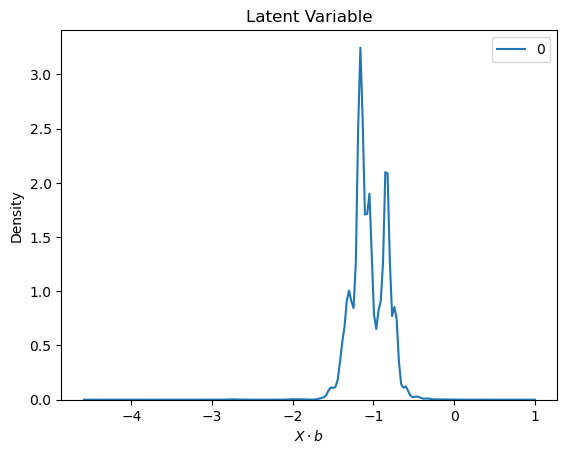

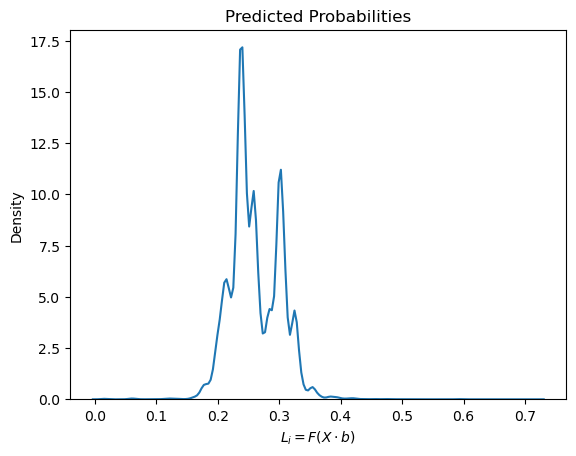

In [11]:
## Run regression:

from sklearn.linear_model import LogisticRegression

# Fit logistic regression:
reg = LogisticRegression(penalty = None,
                         fit_intercept=True, 
                         solver = 'newton-cholesky', 
                         max_iter=1000).fit(X,y)
print('Accuracy: ', reg.score(X,y))

# Latent variable:
latent = np.matmul( X, reg.coef_.T  ) + reg.intercept_
sns.kdeplot(latent).set_title('Latent Variable')
plt.xlabel("$X \\cdot b$")
plt.show()

# Probability of default:
#pr_hat = reg.predict_proba(X)
pr_hat = 1/(1+np.exp(-latent[0]))
sns.kdeplot(x=pr_hat).set_title('Predicted Probabilities')
plt.xlabel("$L_i = F(X \\cdot b$)")
plt.show()


In [12]:
pd.DataFrame({'Variable':reg.feature_names_in_,'Coefficient':reg.coef_[0]})

,Variable,Coefficient
0,Intercept,-8.657416
1,PERSONAL_MONTHLY_INCOME,-0.283741
2,OTHER_INCOMES,-0.158331
3,FLAG_EMAIL,3.639693
4,FLAG_DINERS,250.998456
5,FLAG_AMERICAN_EXPRESS,133.266429
6,FLAG_MASTERCARD,-60.071913
7,FLAG_OTHER_CARDS,17.636640
8,PERSONAL_ASSETS_VALUE,-0.390974
9,0,0.197611


- How does OLS perform?

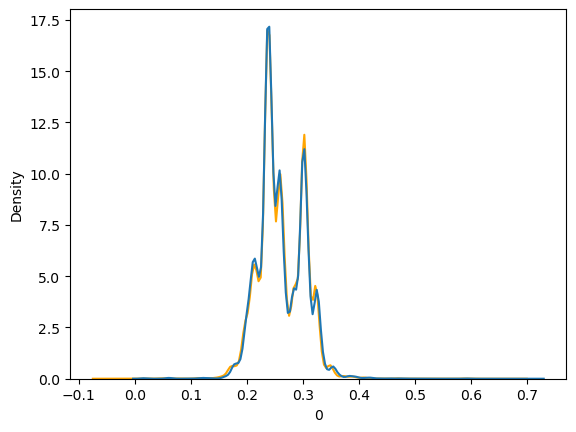

In [13]:
from sklearn.linear_model import LinearRegression

# Fit linear regression:
reg = LinearRegression().fit(X,y)
pr_hat_ols = reg.predict(X)

# Probability of default:
sns.kdeplot(pr_hat_ols,color='orange')#.set_title('Predicted Probabilities')
sns.kdeplot(pr_hat)
plt.show()

- Those are surprisingly close and shows how OLS/linear regression isn't always a bad choice
- What this means is that the latent values for the logistic regression are close enough to zero that you are on the "linear" part of the logistic distribution, so OLS and Logistic Regression deliver very similar results

# Derivative Descent

## "Solving" Non-Linear Models
- With OLS, we can solve the normal equations with linear algebra:
$$
(X'X) \hat{b} = X'y \quad \rightarrow \quad \hat{b} = (X'X)^{-1}(X'y)
$$

- For non-linear models like logistic regression, this kind of inversion isn't possible: The model is non-linear in its parameters, and $b$ doesn't enter the predictive model in a simple, multiplicative way:
$$
\hat{p}_i = \dfrac{1}{1+e^{-x_i \cdot \hat{b}}}
$$
versus
$$
\hat{y} = x_i \cdot \bar{b}
$$
- How do we solve models like this? 

## Minimization by Derivative Descent
- Let's start with functions of a single real variable, to get the intuition for gradient descent
- If you had a quadratic function, like $f(x) = a + bx + cx^2$, $c<0$, you could search for candidate minimizers by taking a derivative, setting equal to zero, and solving:
$$
f'(x^*) = b + 2cx^* = 0 \quad \rightarrow \quad x^* = \dfrac{-b}{2c}
$$

- But the intuition if $f'(x_0)>0$, the function is increasing at $x_0$, and if $f'(x_0)<0$, the function is decreasing at $x_0$...
    1. If $f'(x_0)>0$, decrease $x$
    2. If $f'(x_0)<0$, increase $x$
    3. If $f'(x_0)=0$, we're at a critical point
- So, "To minimize: Move opposite the derivative, until you hit a critical point $x^*$ where $f'(x^*)=0$"
- How would you adjust the rule to maximize a function by derivative descent?

## Practical Derivative Descent
- The derivative typically can't reach exactly zero, because it's an iterative process
    - **We'll stop when the absolute value of the derivative is less than some tolerance, $|f'(x_n)|< \tau$**

- We know to move opposite the derivative, but not how much to increase or decrease $x$
    - **We'll use a step size satisfying $x_{n+1} = x_n - r_n f'(x_n)$, so we take steps opposite the gradient, where we have to pick the step size $r_n$**

- The process might diverge, regardless of whatever choices we make (or because of them)
    - **We'll impose a limit on the maximum number of steps, and report whether the limit is hit**

- We need a starting guess for the algorithm
    - **We often pick this at random and try a few initial guesses, to avoid ending up at a local minimum**

  Final error:  0.0007007637010121304


<Axes: >

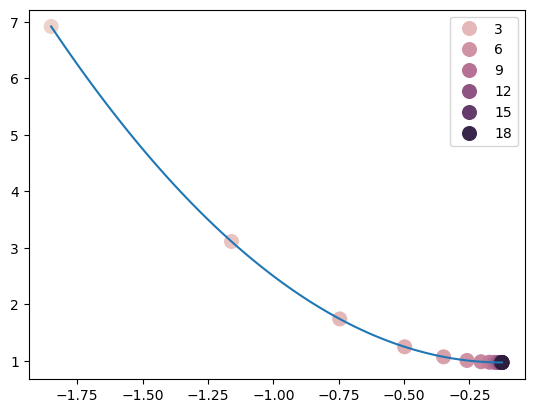

In [14]:
import numpy as np
import seaborn as sns

a = 1.0
b = 0.5
c = 2.0

def f(x): ## Function to optimize
    y = a + b*x + c * np.pow(x,2)
    return y

def df(x): ## Derivative
    y_p = b + 2*c*x
    return y_p

###################################################
###################################################

## Algorithm Parameters:
x_old = -3 # Initial guess
max_iter = 20 # Maximum iterations
step = .1 # Step size
tol = .001 # Convergence tolerance

###################################################
###################################################

err = 100
count = 1
vals = []
points = []
seq = []

## Derivative descent:
while err > tol and count < max_iter:
    ## Compute new x:
    x_new = x_old - step * df(x_old)
    ## Save values:
    points.append( x_new )
    vals.append( f(x_new) )
    seq.append( count )
    ## Update algorithm:
    x_old = x_new
    count = count + 1
    ## Compute current error:
    err = np.abs( df(x_old) )
print('  Final error: ', err)

## Plot:
x_star = -b/(2*c)
x_min = min( x_star, min(points) )
x_max = max( x_star, max(points) )
grid = np.linspace(x_min, x_max, 100)
sns.scatterplot(x=points,y=vals, hue = seq, 
                s= 100, edgecolor=None)
sns.lineplot(x=grid, y = f(grid))

## Another Example
- Let's do another example, with 
$$
f(x) = b \times x - a \times \log(x)
$$
where $a,b>0$. The analytic solution is $ x^* = a/b $.

Final error:  0.0009885344860025569
Number of iterations:  120
Algorithm converged.


<Axes: >

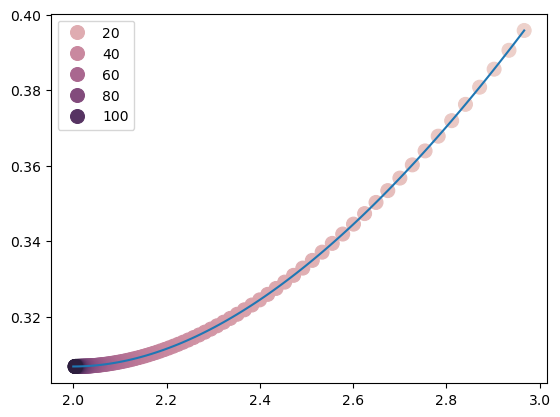

In [15]:
import numpy as np
import seaborn as sns

a = 1.0
b = 0.5
c = 2.0

def f(x): ## Function to optimize
    y = - a* np.log(x) + b * x
    return y

def df(x): ## Derivative
    y_p = -a/x +b
    return y_p

###################################################
###################################################

## Algorithm Parameters:
x_old = 3 # Initial guess
max_iter = 200 # Maximum iterations
step = .2 # Step size
tol = .001 # Convergence tolerance

###################################################
###################################################

err = 100
count = 1
vals = []
points = []
seq = []

## Derivative descent:
while err > tol and count < max_iter:
    ## Compute new x:
    x_new = x_old - step * df(x_old)
    ## Save values:
    points.append( x_new )
    vals.append( f(x_new) )
    seq.append( count )
    ## Compute current error:
    err = np.abs( df(x_old) )
    ## Update algorithm:
    x_old = x_new
    count = count + 1
print('Final error: ', err)
print('Number of iterations: ', count)

if count < max_iter and np.abs(df(x_old))<tol:
    print('Algorithm converged.')
else:
    print('Algorithm failed to converge.')

## Plot:
x_star = a/b
x_min = min( x_star, min(points) )
x_max = max( x_star, max(points) )
grid = np.linspace(x_min, x_max, 100)
sns.scatterplot(x=points,y=vals, hue = seq, 
                s= 100, edgecolor=None)
sns.lineplot(x=grid, y = f(grid))

## Numerical Derivatives
- Sometimes, you can't (or don't want) to compute the derivative yourself
- The **numerical derivative** is
$$
d_h(x) = \dfrac{f\left(x+\frac{h}{2}\right)-f\left(x-\frac{h}{2}\right)}{h}
$$
- So you "straddle" $x$ by $\pm h/2$, and compute the slope of the chord between $x-h/2$ and $x+h/2$
- Obviously, $h$ should be close to zero, but not zero, or the computer will complain (I default to $h = .001$ or $h = .0001$ to start, but I would have trouble justifying that choice mathematically)

Final error:  9.866045536099932e-05
Number of iterations:  165
Algorithm converged.


<Axes: title={'center': 'Convergence'}>

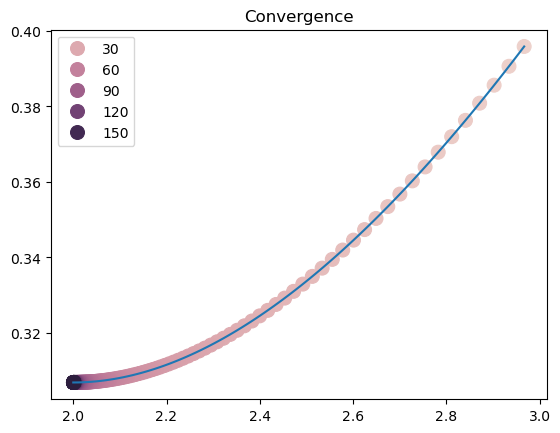

In [16]:
import numpy as np
import seaborn as sns

a = 1.0
b = 0.5
c = 2.0

def f(x): ## Function to optimize
    """ Function to minimize. """
    y = - a* np.log(x) + b * x
    return y

def num_df(f,x,h):
    """ Numerical differentiation of f at x. """
    ndf = ( f(x+h/2) - f(x-h/2) ) / h
    return ndf

###################################################
###################################################

## Algorithm Parameters:
x_old = 3 # Initial guess
max_iter = 200 # Maximum iterations
step = .2 # Step size
h = .001 # Numerical derivative
tol = 1e-4 # Convergence tolerance

###################################################
###################################################

err = 100
count = 1
vals = []
points = []
seq = []

## Derivative descent:
while err > tol and count < max_iter:
    ## Numerical differentiation:
    df = num_df(f,x_old,h)
    ## Compute new x:
    x_new = x_old - step * df
    ## Save values:
    points.append( x_new )
    vals.append( f(x_new) )
    seq.append( count )
    ## Compute current error:
    err = np.abs( df )
    ## Update algorithm:
    x_old = x_new
    count = count + 1
print('Final error: ', err)
print('Number of iterations: ', count)

if count < max_iter:
    print('Algorithm converged.')
else:
    print('Algorithm failed to converge.')

## Plot:
x_star = a/b
x_min = min( x_star, min(points) )
x_max = max( x_star, max(points) )
grid = np.linspace(x_min, x_max, 100)
sns.scatterplot(x=points,y=vals, hue = seq, 
                s= 100, edgecolor=None).set(title='Convergence')
sns.lineplot(x=grid, y = f(grid))

## Practical Intuition
- The initial guess matters:
    - If there are multiple local minima, gradient descent will be drawn to the nearest one to the starting guess. **If you're uncertain of a good initial guess, try many at random.**
- The maximum iteration bound can matter: 
    - If you hit the maximum, you should first relax that constraint and see if the algorithm converges, given more iterations. If it continues to fail, you should pivot to mathematical analysis to see what's going on. **The algorithm might diverge or converge very slowly.**
- The algorithm slows down as it approaches a critical point:
    - because you are getting closer and closer to $f'(x^*)=0$, so the step size is shrinking: Problems that are very flat at their minima or maxima can be tedious to solve. **Good numerical derivatives, step sizes, and initial guesses matter.**

## Is There a Better Step Size?
- If you approximated the derivative $f'$ by a Taylor Series, you would get
$$
f'(x) = f'(a) + (x-a)f''(a) + \cdots
$$

- At the optimum, $f'(x)=0$. Let's impose that, and try to force $x_{n+1}$ be the optimum, as
$$
f'(x_n) + (x_{n+1}-x_n)f''(x_n) = 0
$$
This implies the next step should be
$$
x_{n+1} = x_n - \underbrace{\dfrac{1}{f''(x_n)}}_{\text{step size}}f'(x_n)
$$

- This is called the **Newton(-Raphson) Step**, has excellent convergence properties, and generalizes to higher dimensions in an intuitive way
- Intuition: As $f'(x_n) \rightarrow 0$ as $x_n \rightarrow x^*$, $f''(x_n)$ is probably also getting smaller. Dividing by $f''(x_n)$ then accelerates the optimization process.

Final error:  7.629510948348184e-06
Number of iterations:  5
Algorithm converged.


<Axes: >

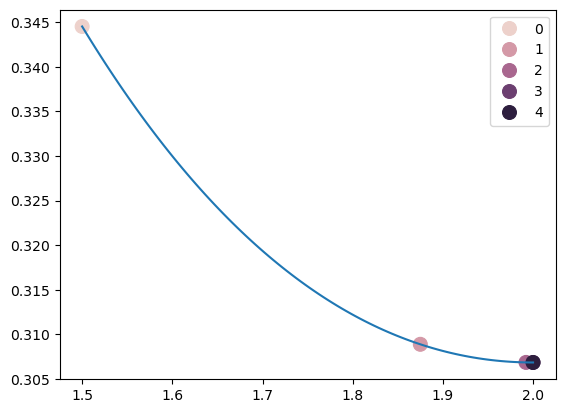

In [17]:
import numpy as np
import seaborn as sns

a = 1.0
b = 0.5
c = 2.0

def f(x): ## Function to optimize
    y = - a* np.log(x) + b * x
    return y

def df(x): ## Derivative
    y_p = -a/x +b
    return y_p

def d2f(x): ## Second derivative
    y_pp = a/x**2
    return y_pp

###################################################
###################################################

## Algorithm Parameters:
x_old = 3 # Initial guess
max_iter = 200 # Maximum iterations
tol = 1e-4 # Convergence tolerance

###################################################
###################################################

err = 100
count = 0
vals = []
points = []
seq = []

## Derivative descent:
while err > tol and count < max_iter:
    ## Compute new x:
    x_new = x_old - df(x_old)/d2f(x_old)
    ## Save values:
    points.append( x_new )
    vals.append( f(x_new) )
    seq.append( count )
    ## Compute current error:
    err = np.abs( df(x_old) )
    ## Update algorithm:
    x_old = x_new
    count = count + 1
print('Final error: ', err)
print('Number of iterations: ', count)

if count < max_iter and np.abs(df(x_old))<tol:
    print('Algorithm converged.')
else:
    print('Algorithm failed to converge.')

## Plot:
x_star = a/b
x_min = min( x_star, min(points) )
x_max = max( x_star, max(points) )
grid = np.linspace(x_min, x_max, 100)
sns.scatterplot(x=points,y=vals, hue = seq, 
                s= 100, edgecolor=None)
sns.lineplot(x=grid, y = f(grid))

- Convergence in 5 iterations, instead of 89
- Why does this work so well? As $x_k$ approaches $x^*$, the step size increases, as the derivative $f''(x_k)$ gets smaller: Because we are confident that we're near the optimum, we optimize faster.

# Gradient Descent

## Multivariate Optimization
- When you go from one variable to many, you replace the derivative with the gradient vector, and the steps are very similar.
- **Gradient Descent is just Derivative Descent, in parallel across all the dimensions at once**
- Despite the added complexity of a multivariate problem, the intuition is almost exactly the same as the one-dimensional case.

## Gradients
- Recall that the gradient generalizes the derivative to $L$ dimensions, and is defined as the column vector 
$$
g(x) = \left[ \begin{array}{c} \partial f(x) / \partial x_1 \\ \partial f(x) / \partial x_2 \\ \vdots \\ \partial f(x) / \partial x_L \end{array} \right]
$$
with
$$
\dfrac{ \partial f(x) }{\partial x_\ell} = \lim_{h \downarrow 0} \dfrac{f(x_1,..., x_\ell + h/2, ... x_L) - f(x_1,..., x_\ell-h/2, ... x_L)}{h}
$$
- Partial derivatives can seem intimidating, but they are just one-dimensional derivatives, holding the other variables constant at the point at which we're differentiating
- The gradient stacks the partial derivatives into a **column vector**.
- The gradient is typically written $\nabla f(x)$, if you are reading something and see that symbol, but we'll call it $g(x)$

## Gradient Descent
- The analogous algorithm for derivative descent, called **gradient descent**, is then given by 
$$
x_{n+1} = x_n - r_n g(x_n)
$$
where $r_n$ is the learning rate
- This does the same thing in each dimension what derivative descent did in one dimension: Move opposite the derivative to reduce the value of the function
- Notice that even though the problem is non-linear, we're still using the notation and ideas of linear algebra

## Example
- Let's start with something simple,
$$
f(x_1, x_2) = x_1 - x_2 + 3 x_1^2 + 3x_1 x_2 + 7 x_2^2
$$
- This is an example of a more general quadratic form in multiple dimensions,
$$
f(x) = \sum_{\ell = 1}^L b_\ell x_\ell + \sum_{i=1}^L \sum_{j=1}^L x_i A_{ij} x_j= x \cdot b + x^{\top}  A \cdot x 
$$


In [18]:
b = np.array([1,-1])
A = np.array([[3, 1.5],
              [1.5,7]])

def f(x):
    """ Function to be minimized: bx + x'Ax. """
    y = np.inner(b,x) + np.inner(x,A@x)
    return y

x_star = np.linalg.solve(2*A,-b) # Compute the actual minimizer
print('Actual minimizer: ', x_star)

def num_gr(f,x,h):
    """ Compute numeric gradient. """
    #gr = b + 2* A @ x 
    L = len(x)
    zero_vector = np.zeros(L)
    gr = []
    for ell in range(L):
        h_ell = zero_vector.copy()
        h_ell[ell] = h
        g_ell = ( f( x + h_ell/2 ) - f( x - h_ell/2 ) )/h
        gr.append(g_ell)
    gr = np.array(gr) # Ensure numpy recognizes it's an array
    return gr

###################################################
###################################################

## Algorithm Parameters:
x_old = np.array([.5,.5]) # Initial guess
max_iter = 200 # Maximum iterations
rate = .05 # Step size
h = .01 # Numerical derivative
tol = 1e-4 # Convergence tolerance

###################################################
###################################################

err = 100
count = 1
vals = []
points = []
seq = []

## Derivative descent:
while err > tol and count < max_iter:
    ## Numerical differentiation:
    df = num_gr(f,x_old,h)
    ## Compute new x by gradient descent:
    x_new = x_old - rate * df
    ## Save values:
    points.append( x_new )
    vals.append( f(x_new) )
    seq.append( count )
    ## Compute current error:
    err = np.inner( df, df )
    ## Update algorithm:
    x_old = x_new
    count += 1

## Results:
print('Final error: ', err)
print('Number of iterations: ', count)
if count < max_iter:
    print('Algorithm converged.')
    print('Computed minimizer: ', x_new)
else:
    print('Algorithm failed to converge.')


Actual minimizer:  [-0.22666667  0.12      ]
Final error:  8.145833980927767e-05
Number of iterations:  22
Algorithm converged.
Computed minimizer:  [-0.22538233  0.11957189]


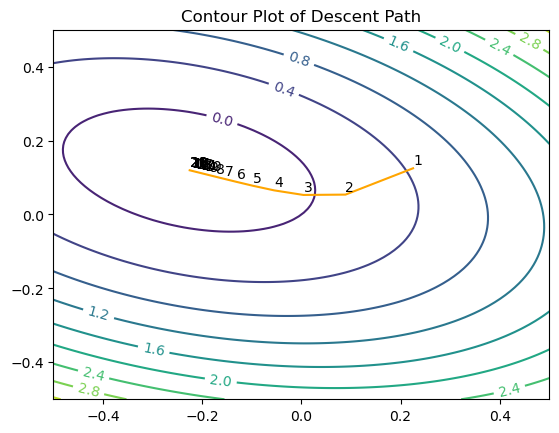

In [19]:
## Illustration of gradient descent:

import numpy as np
import matplotlib.pyplot as plt

K = 100

xvals = []
yvals = []
for i in range(len(points)):
    xvals.append(points[i][0])
    yvals.append(points[i][1])

# x = np.linspace(-.275, .275, K)
# y = np.linspace(-.275, .275, K)
x = np.linspace(-.5, .5, K)
y = np.linspace(-.5, .5, K)

X, Y = np.meshgrid(x, y)

# Calculate the z values for the function
Z = np.zeros((K,K))
for j in range(len(Y)):
    for i in range(len(X)):
        this_ij = np.array([X[i][j],Y[i][j]])
        Z[i,j] = f(this_ij)

# Create the contour plot
fig, ax = plt.subplots()
CS = plt.contour(X, Y, Z, 8) # 20 is the number of contour lines
ax.clabel(CS,fontsize=10)
ax.set_title('Contour Plot of Descent Path')
plt.plot(xvals,yvals,color='orange')
for i in range(len(seq)):
    ax.annotate(seq[i], (xvals[i], yvals[i]+.01))
plt.show()

# Numerically Solving Logistic Regression

## Logistic Regression
- So it turns out: All we need is the gradient to numerically solve our logistic regression problem
- The gradient of the logistic regression objective ends up being surprisingly simple, but it requires a bit of finesse to get there
- The objective function is
$$
L(b) = \dfrac{1}{N} \sum_{i=1}^N y_i \log \left( F(x_i b) \right) + (1-y_i) \log \left( 1-F(-x_i b)\right)
$$

## Logit Magic
- The logistic density has a very cute property:
$$ 
f(z) = F'(z)= \dfrac{e^{-z}}{(1+e^{-z})^2} = \dfrac{1}{1+e^{-z}} \dfrac{e^{-z}}{1+e^{-z}} = F(z)(1-F(z))
$$
- This implies two useful algebraic results that radically simplify things:
$$
\dfrac{f(z)}{1-F(z)} = F(z) \quad \text{ and } \quad \dfrac{f(z)}{F(z)} = 1-F(z) 
$$


## The Logistic Gradient
- By way of logit magic,
\begin{alignat*}{2}
g(b) &=& \dfrac{1}{N} \sum_{i=1}^N \left( y_i \dfrac{f(x_i \cdot b)}{F(x_i \cdot b)} - (1-y_i) \dfrac{f(x_i \cdot b)}{1-F(x_i \cdot b)} \right) x_i^{\top} \quad \text{(Take derivative w.r.t $b$)} \\
&=& \dfrac{1}{N} \sum_{i=1}^N \left( y_i (1-F(x_i \cdot b)) - (1-y_i) F(x_i \cdot b) \right) x_i^{\top} \quad \text{(Logit magic)}\\
&=& \dfrac{1}{N} \sum_{i=1}^N \left( y_i - y_i F(x_i \cdot b) - F(x_i \cdot b) + y_i F(x_i \cdot b) \right) x_i^{\top} \quad \text{(Expand terms)} \\
&=& \dfrac{1}{N} \sum_{i=1}^N \left( y_i - F(x_i \cdot b)  \right) x_i^{\top} \\
\end{alignat*}

- That last line can be vectorized:
$$
g(b) = \frac{1}{N} X^{\top} \cdot (y - \hat{p})
$$
where $\hat{p}_i = 1/(1+e^{-x_i \cdot \hat{\beta}})$ 
- See? It's all linear algebra under the hood. The payoff to learning multivariate calc/linear algebra is that these calculations become natural and clear, instead of mysterious and obscured by notation.

## Gradient Descent with Logistic Regression
- Gradient descent is very easy to implement in NumPy:
$$
b_{k+1} = b_k - r_k \times \frac{1}{N} X^{\top} \cdot (y - F(X \cdot b_k))
$$
or `b_new = b_old - (r/N) * X.T @ (y - F(X@ b_old))`
- For an initial guess for logistic regression, most people start with the zero vector (it is guaranteed to converge, regardless of the initial guess)
- For a step size, the Newton step would be ideal, but $r = .7$ works

In [20]:
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return z

df = pd.read_csv('./data/heart_failure_clinical_records_dataset.csv')
y = df['DEATH_EVENT']
X = df.drop(['DEATH_EVENT', 'time'],axis=1)

X = X.apply( maxmin ) # Maxmin normalize variables

X = pd.concat([pd.DataFrame( {'Intercept': np.ones(X.shape[0])} ),
               X],axis=1) # Add intercept to data
X.head()


,Intercept,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,1.0,0.636364,0.0,0.071319,0.0,0.090909,1.0,0.290823,0.157303,0.485714,1.0,0.0
1,1.0,0.272727,0.0,1.000000,0.0,0.363636,0.0,0.288833,0.067416,0.657143,1.0,0.0
2,1.0,0.454545,0.0,0.015693,0.0,0.090909,0.0,0.165960,0.089888,0.457143,1.0,1.0
3,1.0,0.181818,1.0,0.011227,0.0,0.090909,0.0,0.224148,0.157303,0.685714,1.0,0.0
4,1.0,0.454545,1.0,0.017479,1.0,0.090909,0.0,0.365984,0.247191,0.085714,0.0,0.0


In [21]:
def F(z):
    """Logistic distribution."""
    p = 1/(1+np.exp(-z))
    return p

def grad(b,X,y):
    """Logistic regression gradient."""
    g =  X.T @ ( F(X@b) - y ) / len(y)
    return g

###################################################
###################################################

## Algorithm Parameters:
b_old = np.zeros( X.shape[1] ) # Initial guess
max_iter = 5000 # Maximum iterations
rate = .7 # Learning rate
tol = 1e-7 # Convergence tolerance

###################################################
###################################################

err = 100
count = 0

## Gradient descent:
while err > tol and count < max_iter:
    ## Compute gradient:
    gr = grad(b_old,X,y)
    ## Compute new x:
    b_new = b_old - rate * gr
    ## Compute current error:
    err = np.inner( gr, gr ) 
    ## Update algorithm:
    b_old = b_new
    count += 1
b_gd = b_new 

## Results:
print('Final error: ', err)
print('Number of iterations: ', count)
if count < max_iter:
    print('Algorithm converged.')
    print('Computed minimizer: \n', b_gd)
else:
    print('Algorithm failed to converge.')


Final error:  9.986613789832373e-08
Number of iterations:  2885
Algorithm converged.
Computed minimizer: 
 Intercept                   0.174838
age                         3.057010
anaemia                     0.413665
creatinine_phosphokinase    2.249569
diabetes                    0.148531
ejection_fraction          -4.610393
high_blood_pressure         0.413016
platelets                  -0.585025
serum_creatinine            5.671260
serum_sodium               -2.025190
sex                        -0.397195
smoking                     0.130949
dtype: float64


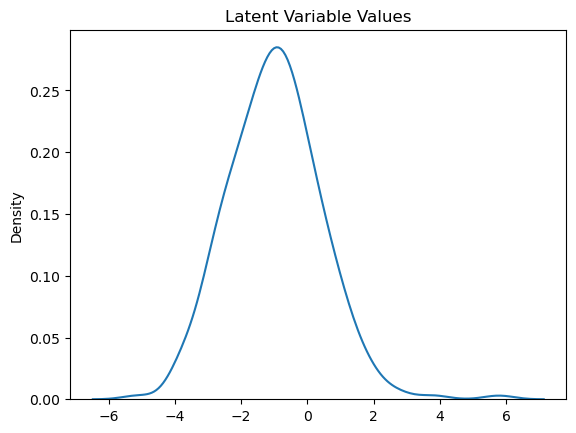

count    299.000000
mean       0.321112
std        0.234014
min        0.005931
25%        0.124275
50%        0.269797
75%        0.468181
max        0.996911
dtype: float64


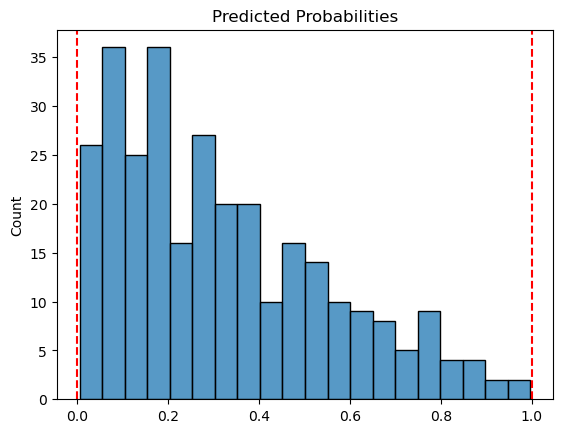

In [22]:
latent = X@b_new
sns.kdeplot(latent).set(title='Latent Variable Values')
plt.show()

p_hat = F(latent)
print( p_hat.describe() )
sns.histplot(p_hat,bins=20).set(title='Predicted Probabilities')
plt.axvline(x=0, color='red', linestyle='--')
plt.axvline(x=1, color='red', linestyle='--')

Text(0.5, 1.0, 'Predicted Probabilities')

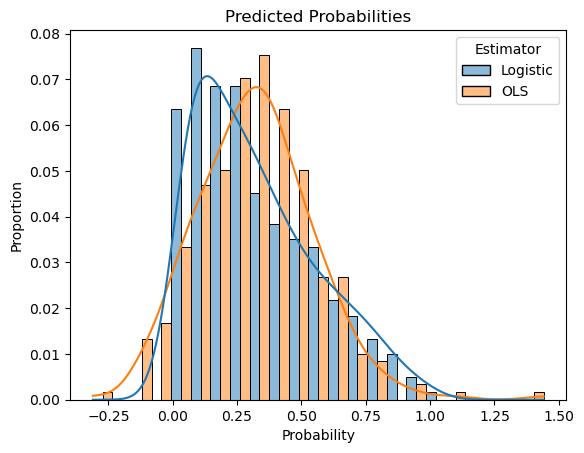

In [23]:
from sklearn.linear_model import LinearRegression

# Fit linear regression:
reg = LinearRegression().fit(X,y)
p_hat_ols = reg.predict(X)

gdf = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'Probability': p_hat, 'Estimator': 'Logistic'}),
    pd.DataFrame.from_dict({'Probability': p_hat_ols, 'Estimator': 'OLS'})])

# Probability of default:
sns.histplot(data=gdf, x='Probability', hue='Estimator', kde=True, alpha=.5,
             stat='proportion',multiple='dodge').set_title('Predicted Probabilities')

In [24]:
## Comparison with Sci-Kit:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty=None, fit_intercept=False).fit(X,y)

## Comparison with StatsModels:
import statsmodels.api as sm
lr_sm = sm.Logit(y,X).fit()

## Side-by-side:
pd.DataFrame({'gradientDescent':b_gd, 'sklearn':LR.coef_[0] ,'statsModels':lr_sm.params})

Optimization terminated successfully.
         Current function value: 0.492108
         Iterations 6


,gradientDescent,sklearn,statsModels
Intercept,0.174838,0.135365,0.123896
age,3.057010,3.063804,3.063001
anaemia,0.413665,0.416153,0.417930
creatinine_phosphokinase,2.249569,2.261576,2.277260
diabetes,0.148531,0.152032,0.151408
ejection_fraction,-4.610393,-4.644633,-4.641254
high_blood_pressure,0.413016,0.419767,0.418938
platelets,-0.585025,-0.603590,-0.585154
serum_creatinine,5.671260,5.892794,5.890559
serum_sodium,-2.025190,-1.989499,-1.983335


## Logistic Regression
- So our code yields almost the same results as Sci-Kit and StatsModels... but in thousands more iterations
- To improve our code, we'd need to work a lot on picking a better step size, but we'll stop here with numerical methods
- Remember, the goal here is to de-mystify what's happening when you call an algorithm like Linear Regression or Logistic Regression: You don't (and in most cases, shouldn't) need to write your own code to do this. But because you understand how it works, you're not at the mercy of the machine. 

## Newton-Raphson
- Just out of curiosity!
- Just so you can see that it's not **that** hard to get SciKit/StatsModels-type performance, let's see that you can achieve Scikit/StatsModels speed by using the Newton-Raphson step for logistic regression:
$$
b_{k+1} = b_k  - \underbrace{(X'DX)^{-1}}_{\text{Learning rate}} \quad \underbrace{X'(\hat{p}-y)}_{\text{Gradient}}
$$
where $D$ is a diagonal matrix with diagonal elements $D_{ii} = \hat{p}_i(1-\hat{p}_i)$.
- Note how the step size now depends on $b_k$ through $D$ through $\hat{p}$: This is what speeds learning up as we approach the minimizer
- Note the continued ubiquity of linear algebra, despite the non-linearity of the model and the method

In [25]:
def F(z):
    """Logistic distribution."""
    p = 1/(1+np.exp(-z))
    return p

def grad(b,X,y):
    """Logistic regression gradient."""
    g =  X.T @ ( F(X@b) - y ) / len(y)
    return g

def hess(b,X,y,R):
    """Logistic regression Hessian."""
    s = F(X@b)*(1-F(X@b))
    D = (np.diag(s)+R)
    H = X.T @ D @ X / len(y)
    return H
    
###################################################
###################################################

## Algorithm Parameters:
b_old = np.zeros( X.shape[1] ) # Initial Guess
max_iter = 5000 # Maximum Iterations
tol = 1e-5 # Convergence tolerance

###################################################
###################################################

err = 100
count = 0

## Gradient descent:
while err > tol and count < max_iter:
    ## Compute gradient, Hessian:
    gr = grad(b_old,X,y)
    H = hess(b_old,X,y,.001)
    ## Compute new x:
    b_new = b_old - np.linalg.inv(H) @ gr # use irls, not inversion
    ## Compute current error:
    err = np.inner( gr, gr ) 
    ## Update algorithm:
    b_old = b_new
    count += 1
b_nr = b_new

## Results:
print('Final error: ', err)
print('Number of iterations: ', count)
if count < max_iter:
    print('Algorithm converged.')
    print('Computed minimizer: \n', b_nr)
else:
    print('Algorithm failed to converge.')


Final error:  5.038652094226723e-06
Number of iterations:  13
Algorithm converged.
Computed minimizer: 
 [ 0.12630528  3.05509202  0.41697921  2.27210784  0.15058271 -4.62737688
  0.41843214 -0.58077287  5.88807403 -1.98078604 -0.39782207  0.13556661]


In [26]:
pd.DataFrame({'gradientDescent':b_gd,'NewtonRaphson':b_nr, 'sklearn':LR.coef_[0] ,'statsModels':lr_sm.params})

,gradientDescent,NewtonRaphson,sklearn,statsModels
Intercept,0.174838,0.126305,0.135365,0.123896
age,3.057010,3.055092,3.063804,3.063001
anaemia,0.413665,0.416979,0.416153,0.417930
creatinine_phosphokinase,2.249569,2.272108,2.261576,2.277260
diabetes,0.148531,0.150583,0.152032,0.151408
ejection_fraction,-4.610393,-4.627377,-4.644633,-4.641254
high_blood_pressure,0.413016,0.418432,0.419767,0.418938
platelets,-0.585025,-0.580773,-0.603590,-0.585154
serum_creatinine,5.671260,5.888074,5.892794,5.890559
serum_sodium,-2.025190,-1.980786,-1.989499,-1.983335


- 13 iterations instead of 2885
- There is an even better method called Iteratively Reweighted Least Squares, which is what StatsModels is most likely doing
- So, again, these packages aren't doing anything magical: Just applying basic concepts from numerical methods and machine learning

# Multinomial Logit

## Categorical Prediction
- Binary logistic regression solves one of our problems with linear models: Predicted values might be below zero or above one
- Is there a version of logistic regression for truly categorical problems with more than two potential outcomes?
- Yes, it's called multinomial logit
- Essentially, you introduce a latent variable for each potential outcome

## Multinomial Logit
- If you have more than two discrete outcomes, you can still use a logistic model, unlike the Linear Probability Model
- For each outcome $k=1,...,K$, you have a latent variable $L_{ik} = \beta_k \cdot x_i + \varepsilon_{ik}$
- The outcome is the maximum value over all the latent indices $(L_{i1}, L_{i2}, ..., L_{iK})$: 
$$
y_{ik} = \begin{cases}
1, & \quad  L_{ik} > L_{ij}, j \neq k\\
0, & \quad \text{otherwise.}
\end{cases}
$$
- So for each observation $i$ and outcome $k$, we just observe whether $i$ chose $k$ or not, and not the latent indices $L_{ik}$
- We want to recover the underlying mean preferences, the $\beta_1, ..., \beta_K$ coefficients

## Multinomial Logit
- You can show that
$$ pr[y_{ik} = 1] = \begin{cases}
\dfrac{e^{\beta_k \cdot x_i}}{1+\sum_{j=1}^{K-1} e^{\beta_j \cdot x_i}}, & \quad k<K\\
\dfrac{1}{1+\sum_{j=1}^{K-1} e^{\beta_j \cdot x_i}}, & \quad k = K
\end{cases}
$$
and fit the model using maximum likelihood,
$$L(\beta_1, \beta_2, ..., \beta_{K-1}) = \prod_{i = 1}^{N} \left( \dfrac{e^{\beta_1 \cdot x_i}}{1+\sum_{j=1}^{K-1} e^{\beta_j \cdot x_i}} \right)^{y_{i1}} \left( \dfrac{e^{\beta_2 \cdot x_i}}{1+\sum_{j=1}^{K-1} e^{\beta_j \cdot x_i}} \right)^{y_{i2}} \cdot \cdot \cdot \left( \dfrac{e^{\beta_{K-1} \cdot x_i}}{ 1+\sum_{j=1}^{K-1} e^{\beta_j \cdot x_i}}\right)^{y_{i,K-1}}
$$

## Categorical Cross Entropy
- That likelihood looks nasty: Stats people take logs, and instead maximize the log likelihood,
$$
\ell \ell(b) = \frac{1}{N} \sum_{i=1}^N \sum_{k=1}^{K-1} y_{ik} \log( \hat{p}_{ik})
$$
while CS people minimize the categorical cross entropy,
$$
\text{cce}(b) = - \dfrac{1}{N} \sum_{i=1}^N \sum_{k=1}^{K-1} y_{ik} \log( \hat{p}_{ik})
$$
- The intuition is that the misclassification error is determined by the true class label for each observation $i$, $y_{ik}$, and the further $\hat{p}_{ik}$ is from 1, the bigger the loss will be 


## Example: Landmines
- There are five kinds of landmines, which must be disarmed in different ways
- There are three predictor/feature/covariates available: voltage, height, and soil
- We want to build a model to predictive model to aid people in decision-making when facing these devices

In [27]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

mdf = pd.read_csv('./data/land_mines.csv') # landmine data

## Data for sklearn
y_mines = mdf['mine_type']
X_mines = mdf.drop('mine_type',axis=1)

## Run Logistic Regression
mnl = LogisticRegression(penalty=None).fit(X_mines,y_mines)

## Regression coefficients
mnl_coef = pd.DataFrame(mnl.coef_)
mnl_coef = mnl_coef.set_axis(mnl.feature_names_in_,axis=1)
print('Coefficients for each landmine type:')
mnl_coef


Coefficients for each landmine type:


,voltage,height,soil
0,-27.160473,-4.217283,1.008841
1,37.249504,9.236162,-2.769627
2,3.838236,-0.407835,0.267610
3,-11.667221,-3.071488,0.833919
4,-2.260045,-1.539557,0.659257


In [28]:
pd.DataFrame(mnl.predict_proba(X_mines)) # For each landmine, what's the probability of each type?

,0,1,2,3,4
0,0.452967,0.000009,0.066211,0.346619,0.134195
1,0.456547,0.000031,0.076554,0.325986,0.140882
2,0.577952,0.000016,0.048908,0.273674,0.099450
3,0.641892,0.000028,0.041890,0.232563,0.083627
4,0.570119,0.000129,0.064459,0.253743,0.111550
...,...,...,...,...,...
333,0.139971,0.045524,0.305945,0.224695,0.283866
334,0.073745,0.000336,0.274076,0.301256,0.350587
335,0.247693,0.000129,0.156706,0.339611,0.255861
336,0.121238,0.004442,0.287099,0.261459,0.325763


In [29]:
pd.crosstab( y_mines, mnl.predict(X_mines)) 

col_0,1,2,3,4,5
mine_type,,,,,
1,60,0,2,7,2
2,0,62,8,0,0
3,3,3,31,16,13
4,21,2,21,8,14
5,7,0,25,18,15


In [30]:
tab = pd.crosstab( y_mines, mnl.predict(X_mines)) 
acc = np.trace(tab)/len(y_mines)
print('Accuracy: ', acc)

Accuracy:  0.5207100591715976


## Multinomial Logit
- You can motivate multinomial logit the same way we motivated logistic regression: There's a latent index $L_{ik} = x_i \cdot \beta_k + \varepsilon_{ik}$, and the maximum of those latent values is observed
- Classification looked like it would be hard or impossible to do with a linear index function: So use a bunch of index functions, one for each option
- Of course, you can use multinomial logit for any classification situation in which you want a more explainable approach than, say, $k$-NN

# Conclusion

## Logistic Regression and Neural Networks
- Logistic regression is a really powerful, useful tool in its own right
    - Binary version is useful for predicting probabilities
    - Multinomial version has the benefits of a linear latent variable, but predicts categorical outcomes 
- This is also a good time to learn about gradient descent, and see how you can numerically minimize or maximize functions on a computer
- An ulterior motive is to foreshadow neural networks: The simplest one-layer neural networks with a sigmoid activation function **are** logistic regression, and more complex neural networks are roughly a bunch of latent variables and logistic distribution functions wired together